In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm

import sys
sys.path.insert(0, '..')
from utils.plot_lib import set_default

set_default(figsize=(6, 4))

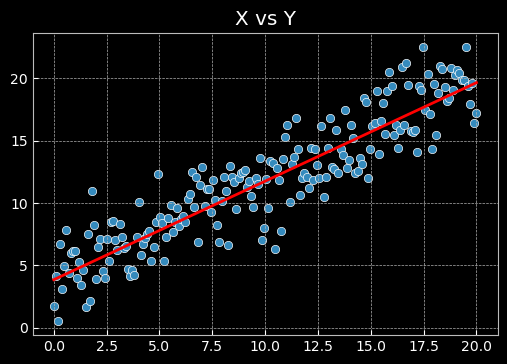

In [37]:
# Creating data for LR
b = 3.84
m = 0.79
X = np.linspace(0, 20, num=200)
Y = b + m * X + np.random.normal(0, 2, 200)
y_true = b + m * X

# Plotting infant vs income
sns.scatterplot(X, Y, x="x", y="y")
sns.lineplot(X, y_true, color = 'red')
plt.title('X vs Y')
plt.show()

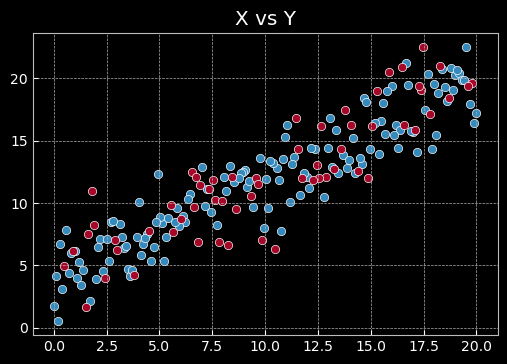

X train size is: (140,)
X Test size is: (60,)
Y train size is: (140,)
Y test size is: (60,)


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Plotting infant vs income
sns.scatterplot(X_train, y_train, x="x", y="y")
sns.scatterplot(X_test, y_test, x="x", y="y")
plt.title('X vs Y')
plt.show()

print('X train size is: {}'.format(X_train.shape))
print('X Test size is: {}'.format(X_test.shape))
print('Y train size is: {}'.format(y_train.shape))
print('Y test size is: {}'.format(y_test.shape))

Recall that for a Bayesian linear regression, the model should be (in this particular case)

$y = ax + b + \epsilon \text{ with } \epsilon \sim \mathcal{N}(0, \sigma^2)$

$y \sim \mathcal(\beta_0 + \beta_1 X, \sigma^2)$

$\beta_0 \sim \mathcal{N}(0, 20)$

$\beta_1 \sim \mathcal{N}(0, 20)$

$ \epsilon \sim \text{Gamma}(5/2, (5 * 10)/2)$

In [39]:
with pm.Model() as lr:
    # Definen priors of parameters
    b_0 = pm.Normal('intercept', 0, 20) # Non informative prior
    b_1 = pm.Normal('slope', 0, 20) # Non informative prior
    prior_sz = 5 # Prior sample size
    priot_gss = 10 # Prior guess for variance 
    prec = pm.Gamma('epsilon', alpha = prior_sz / 2.0, beta = prior_sz * priot_gss / 2.0)
    
    x_ = pm.Data('features', X_train) # a data container, can be changed

    # Likelihood
    obs = pm.Normal('observation', b_0 + b_1 * x_, prec, observed = y_train)

In [40]:
with lr:
    # Use MCMC to sample 10000 samples
    trace = pm.sample(10000, tune = 1000)
    # Tune gives a number of samples to reject. These are used to calibrate the sampler. 
    # After the number of samples in tune, the following are considered useful.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, slope, intercept]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.893859178473341, but should be close to 0.8. Try to increase the number of tuning steps.


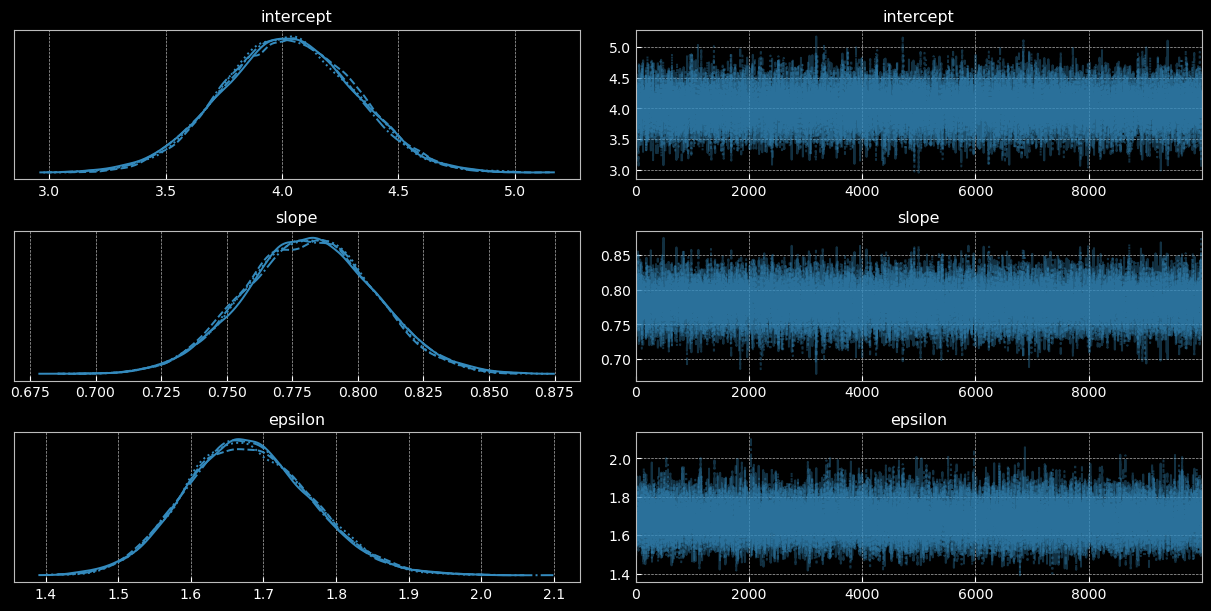

In [41]:
# Plotting posterior distribution of mu
az.plot_trace(trace)
plt.show()

In [42]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,4.025,0.283,3.499,4.555,0.002,0.002,17518.0,17511.0,17507.0,19107.0,1.0
slope,0.781,0.024,0.734,0.825,0.000,0.000,17736.0,17734.0,17711.0,18859.0,1.0
epsilon,1.680,0.086,1.520,1.841,0.001,0.000,21647.0,21473.0,21844.0,20582.0,1.0


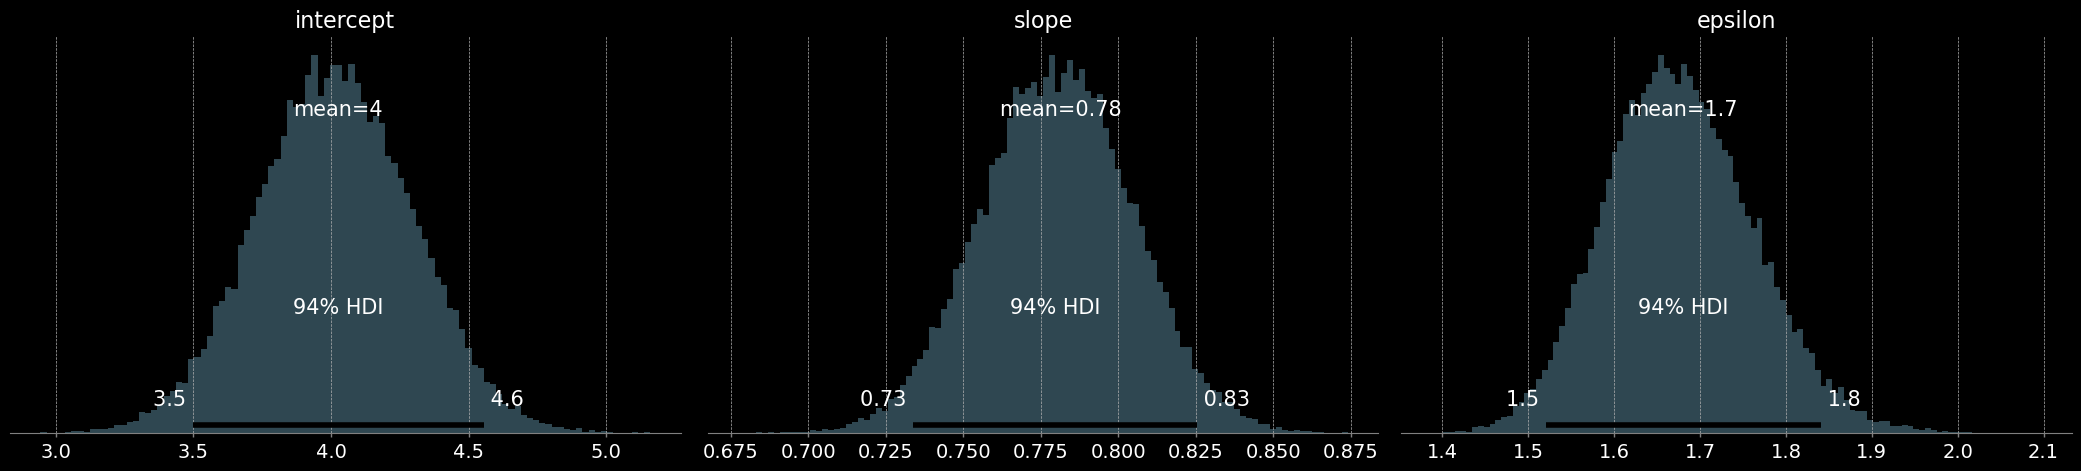

In [43]:
az.plot_posterior(trace, point_estimate = 'mean', kind = 'hist', color= "#87ceeb")
plt.show()

In [66]:
# Arranging data
test_data = np.vstack((X_test, y_test)).T
test_data_df = pd.DataFrame(data = test_data, columns=["X", "Y"])
test_data_df = test_data_df.sort_values('X')
print(test_data_df.head())

X_test = test_data_df['X'].to_numpy()
y_test = test_data_df['Y'].to_numpy()

           X          Y
52  0.502513   4.958315
30  0.904523   6.130930
1   1.507538   1.633848
21  1.608040   7.541313
31  1.809045  10.990135


In [68]:
with lr:
    pm.set_data({'features': X_test})
    posterior = pm.sample_posterior_predictive(trace)

y_pred = posterior['observation']
print('The shape of the observations is: {}'.format(y_pred.shape))

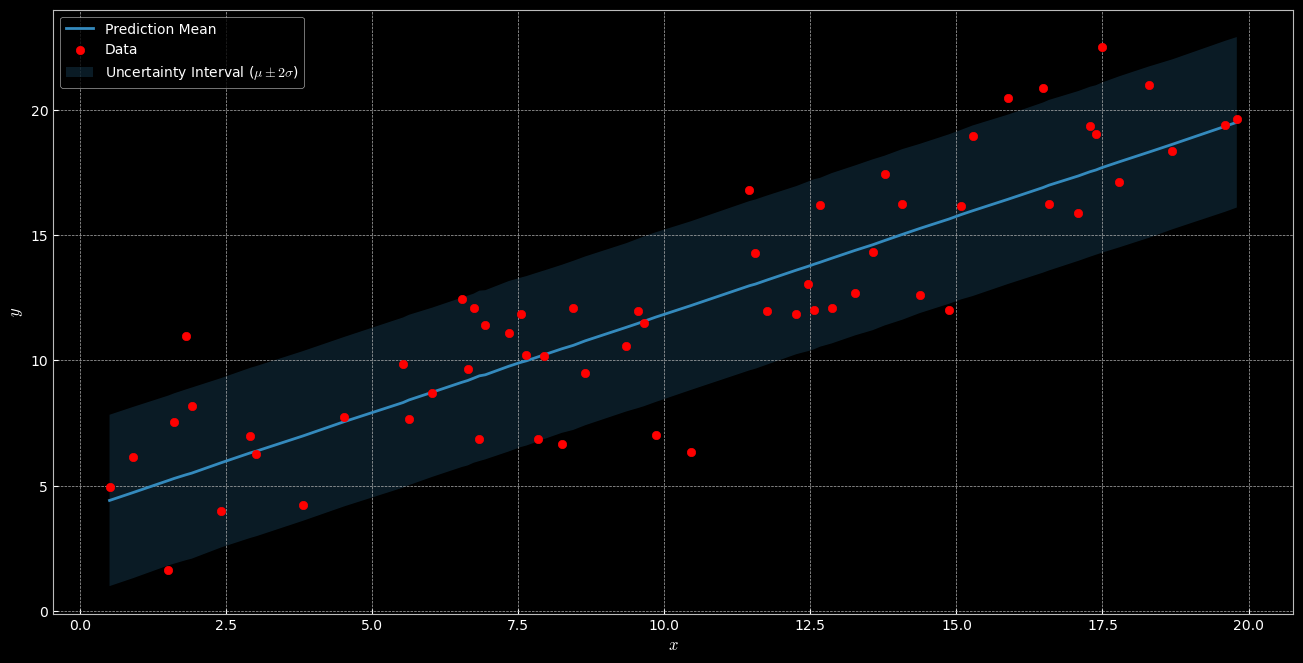

In [72]:
y_mean = y_pred.mean(axis=0).ravel()
y_std = y_pred.std(axis=0).ravel()
plt.figure(figsize=(16, 8))
plt.scatter(X_test, y_test, c='red', zorder=10, label='Data')
plt.plot(X_test, y_mean, label= 'Prediction Mean' )
plt.fill_between(X_test.ravel(), y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.2, label='Uncertainty Interval ($\mu\pm2\sigma$)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend(loc='upper left')
plt.show()